In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv('googleplaystore.csv')

In [55]:
# Function to get user input
def get_user_input():
    print("Enter the following details for the app:")

    # Input from user
    rating = float(input("Rating (numeric value between 1 to 5): "))
    reviews = input("Reviews (numeric value): ")
    size = input("Size (e.g., '10M' or '15k'): ")
    price = input("Price (e.g., '$0.99'): ")
    android_ver = input("Android Version (e.g., '4.1 and up'): ")
    category = input("Category (e.g., 'GAME'): ")
    app_type = input("App Type (e.g., 'Paid' or 'Free'): ")
    content_rating = input("Content Rating (e.g., 'Everyone'): ")
    genres = input("Genres (e.g., 'Action'): ")

    # Return the input as a dictionary
    return {
        'Rating': rating,
        'Reviews': reviews,
        'Size': size,
        'Price': price,
        'Android Ver': android_ver,
        'Category': category,
        'Type': app_type,
        'Content Rating': content_rating,
        'Genres': genres
    }

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
Data Info:
 None

Summary Statistics:
            App Category       Rating Reviews                Size    Installs  \
count    10841    10841  9367.000000   10841

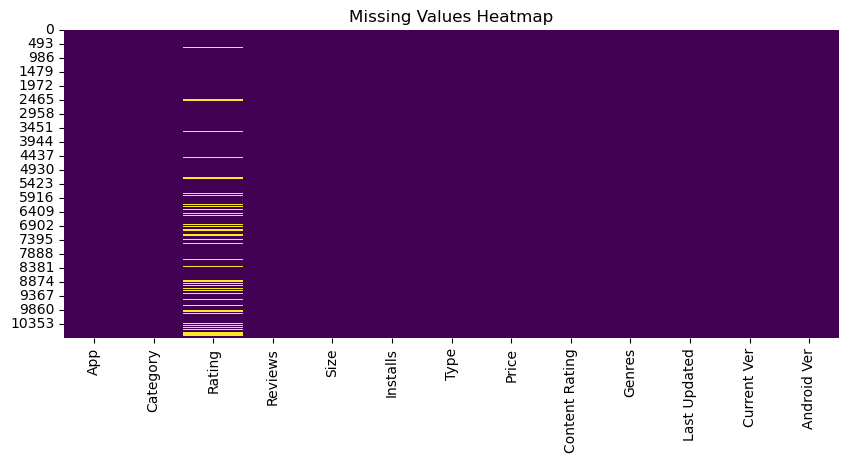

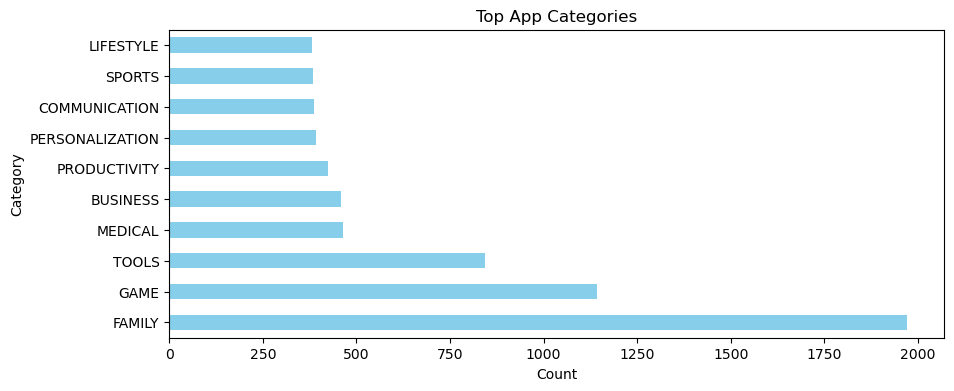

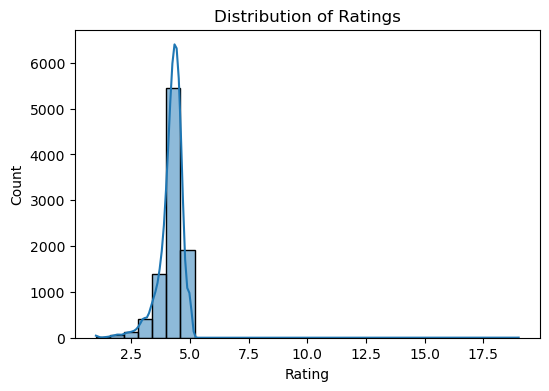

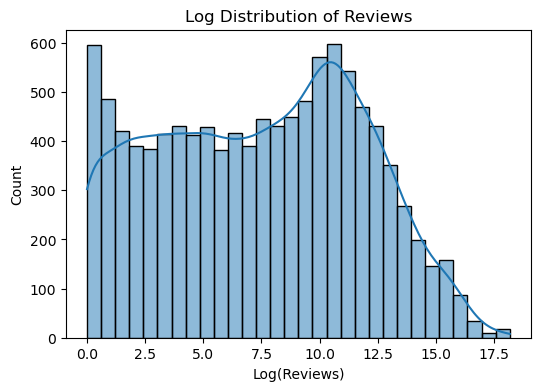

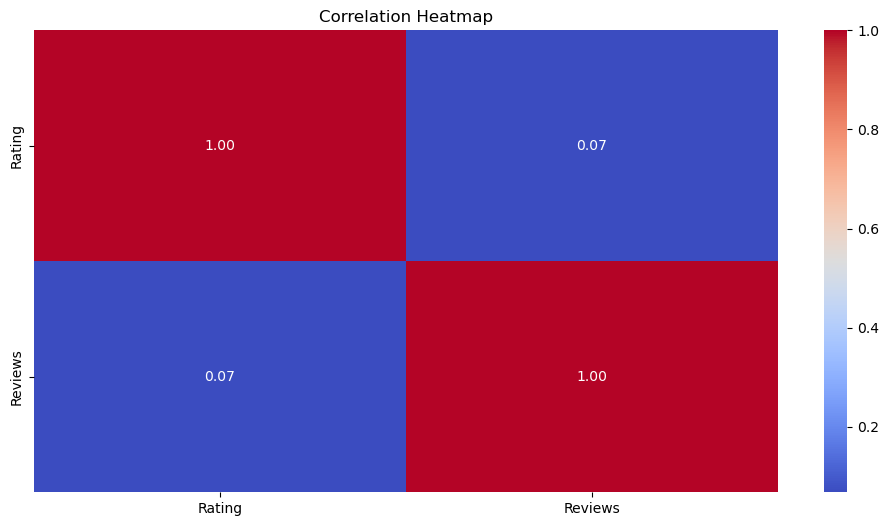

In [57]:
# -------------------- EDA -------------------- #
def perform_eda(df):
    print("Data Info:\n", df.info())
    print("\nSummary Statistics:\n", df.describe(include='all'))

    # Visualize missing values
    plt.figure(figsize=(10, 4))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

    # Visualize target (Success) distribution later

    # Top categories
    if 'Category' in df.columns:
        plt.figure(figsize=(10, 4))
        df['Category'].value_counts().head(10).plot(kind='barh', color='skyblue')
        plt.title('Top App Categories')
        plt.xlabel('Count')
        plt.ylabel('Category')
        plt.show()

    # Distribution of Ratings
    if 'Rating' in df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df['Rating'].dropna(), kde=True, bins=30)
        plt.title('Distribution of Ratings')
        plt.xlabel('Rating')
        plt.show()

    # Distribution of Reviews
    if 'Reviews' in df.columns:
        plt.figure(figsize=(6, 4))
        df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
        sns.histplot(np.log1p(df['Reviews'].dropna()), bins=30, kde=True)
        plt.title('Log Distribution of Reviews')
        plt.xlabel('Log(Reviews)')
        plt.show()

    # Correlation Heatmap (numerical)
    numeric_df = df.select_dtypes(include=[np.number])
    correlation = numeric_df.corr()
    plt.figure(figsize=(12, 6))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

# Run EDA
perform_eda(df)


In [7]:
# -------------------- DATA CLEANING -------------------- #
df.drop(['App', 'Last Updated', 'Current Ver'], axis=1, inplace=True)

# Android Ver cleaning
def extract_android_ver(ver):
    try:
        return float(ver.split()[0])
    except:
        return np.nan

df['Android Ver'] = df['Android Ver'].apply(extract_android_ver)
df['Android Ver'].fillna(df['Android Ver'].median(), inplace=True)

# Fill Rating & drop remaining NaNs
df['Rating'].fillna(df['Rating'].median(), inplace=True)
df.dropna(inplace=True)

# Reviews to log scale
df['Reviews'] = np.log1p(pd.to_numeric(df['Reviews'], errors='coerce'))

# Clean Installs & create Success target
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True).astype(int)
df['Success'] = np.where(df['Installs'] > 100000, 1, 0)

# Price to log scale
df['Price'] = np.log1p(df['Price'].str.replace('$', '').astype(float))

# Handle Size
def size_to_kb(size):
    try:
        if size.endswith('M'):
            return np.log1p(float(size[:-1]) * 1024)
        elif size.endswith('k'):
            return np.log1p(float(size[:-1]))
        else:
            return np.nan
    except:
        return np.nan

df['Size'] = df['Size'].apply(lambda x: size_to_kb(x) if x not in ['Varies with device'] else np.nan)
df['Size'].fillna(df['Size'].median(), inplace=True)

# Feature: Price per MB
df['Price_per_MB'] = df['Price'] / (df['Size'] + 1e-6)

# Encode categoricals
df = pd.get_dummies(df, columns=['Category', 'Type', 'Content Rating', 'Genres'], drop_first=True)

In [65]:
# -------------------- MODELING -------------------- #
X = df.drop(['Success', 'Installs'], axis=1)
y = df['Success']

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Evaluation Function
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f'\n{model_name} Performance:')
    print(f'Accuracy: {acc * 100:.2f}%')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return acc

# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(512,256,128), max_iter=300, random_state=42)
}



accuracies = {}
for name, model in models.items():
    accuracies[name] = evaluate_model(model, name)

KeyError: "['Success'] not found in axis"

In [48]:
# -------------------- HYPERPARAMETER TUNING -------------------- #
param_grid = {
    'hidden_layer_sizes': [(512, 256, 128), (256, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}


grid_search = GridSearchCV(MLPClassifier(max_iter=300, random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
best_nn_model = grid_search.best_estimator_
evaluate_model(best_nn_model, "Optimized Neural Network")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

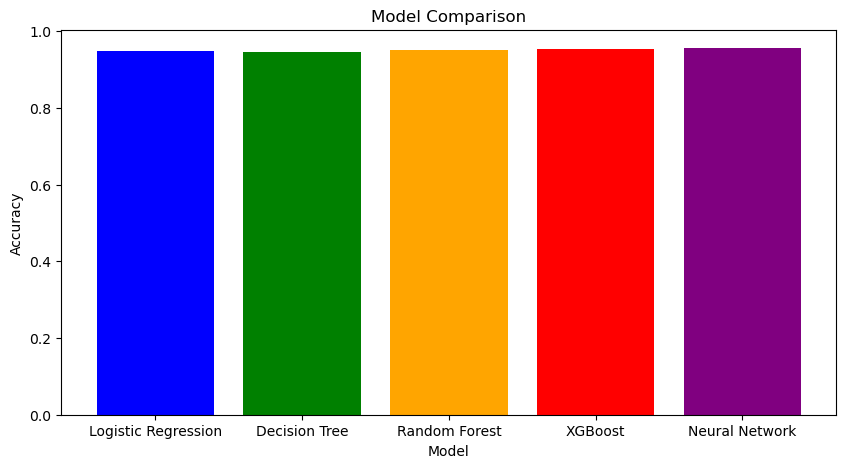

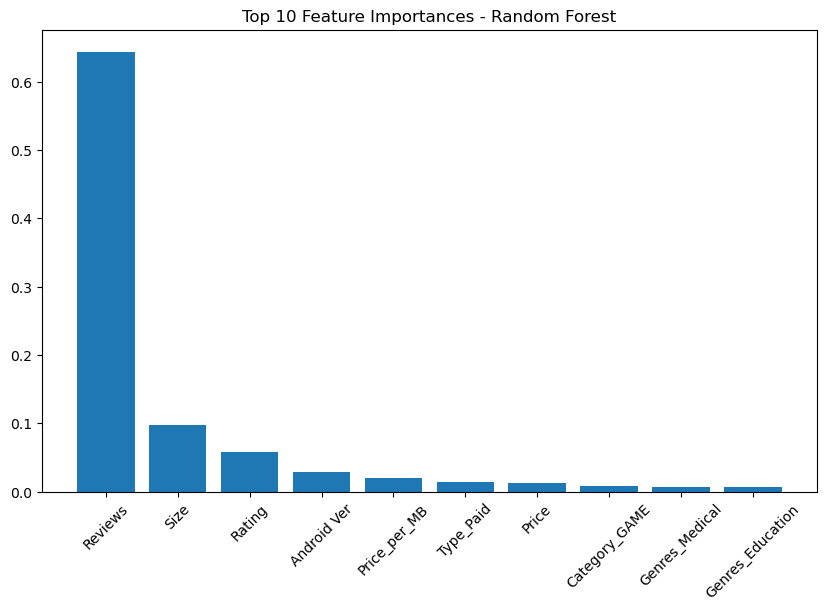


✅ The best model is **Neural Network** with an accuracy of **0.96%**


In [14]:
# -------------------- COMPARISON & FEATURE IMPORTANCE -------------------- #
# Accuracy bar chart
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

# Feature importance - Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances - Random Forest')
plt.bar(range(10), importances[sorted_indices][:10], align='center')
plt.xticks(range(10), [feature_names[i] for i in sorted_indices[:10]], rotation=45)
plt.show()

# Best model
best_model_name = max(accuracies, key=accuracies.get)
print(f'\n✅ The best model is **{best_model_name}** with an accuracy of **{accuracies[best_model_name]:.2f}%**')

In [46]:
import joblib

# Save the trained model
joblib.dump(nn_model, 'neural_network_model.pkl')

# Save the feature columns
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')


NameError: name 'nn_model' is not defined